# Feature Analysis Using a Neural Network

__Notebook Author__: Hamed Qazanfari

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamedmit/VisionLab/blob/main/NN_for_Feature_Analysis.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/hamedmit/VisionLab/blob/main/NN_for_Feature_Analysis.ipynb)

---
## Notebook Objectives

This notebook implements and analyzes a feedforward neural network trained on the MNIST dataset for digit classification.

Workflow:
- 1️⃣ Loading Data: The MNIST dataset is downloaded and converted into tensors.
- 2️⃣ Training the Network: A neural network with two hidden layers is trained to classify images into digit classes (0-9).
- 3️⃣ Feature Visualization: The output of the last hidden layer is extracted and visualized using PCA and t-SNE.
- 4️⃣ Class Separation Analysis: The visualization shows whether the last hidden layer makes different digit classes linearly separable.



In [1]:
# setup and imports

import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.mnist import MNIST
from torchvision.datasets.cifar import CIFAR10

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# plotting functions

def plot_history(history):
    if 'train_acc' in history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['train_loss'], label='train')
        ax1.plot(history['test_loss'], label='test')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(history['train_acc'], label='train')
        ax2.plot(history['test_acc'], label='test')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['test_loss'], label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()


def plot_conf_mat(model, dataloader, device=device):
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def visualize(embedded, labels, title=''):
    fig, ax = plt.subplots(figsize=(12,8))

    # get discrete colormap
    cmap = plt.get_cmap('jet', 10) # virdis

    # plot scatter points
    scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap=cmap)

    # add colorbar
    cbar = plt.colorbar(scatter)

    # set ticks locations
    cbar.set_ticks((np.arange(10) + 0.5) * (10 - 1) / 10)

    # set tick labels
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title(title)
    plt.show()


def plot_last_hidden_layer(model, dataloader, method='PCA'):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.last_hidden_layer(imgs.to(device))
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using t-SNE'

    visualize(embedded, labels, title)



In [ ]:
# MNIST dataset

batch_size = 256

trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Neural Network

First, we train a simple neural network and analyze its last hidden layer. To do this, we define the last_hidden_layer function to extract its output.

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fe = nn.Sequential(nn.Linear(784, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 64),
                                nn.ReLU(inplace=True))
        self.fc = nn.Linear(64, 10)

    def last_hidden_layer(self, x):
        x = torch.flatten(x, start_dim=1) / 255.
        return self.fe(x)

    def forward(self, x):
        out = self.last_hidden_layer(x)
        out = self.fc(out)
        return out

In [10]:
# Neural Netwrok helper functions

def classifier_train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def classifier_test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_acc += (logits.argmax(dim=1) == labels).sum().item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader.dataset)
    return test_loss, test_acc


def train_classifier(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    optimizer = Adam(model.parameters())
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = classifier_train_step(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        test_loss, test_acc = classifier_test_step(model, test_dataloader, loss_fn, device)
        history['test_loss'].append(test_loss), history['test_acc'].append(test_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Test Accuracy {100 * test_acc:.2f}% ')
    return history

Training Accuracy 95.03% | Test Accuracy 94.84% : 100%|██████████| 30/30 [05:57<00:00, 11.92s/it]


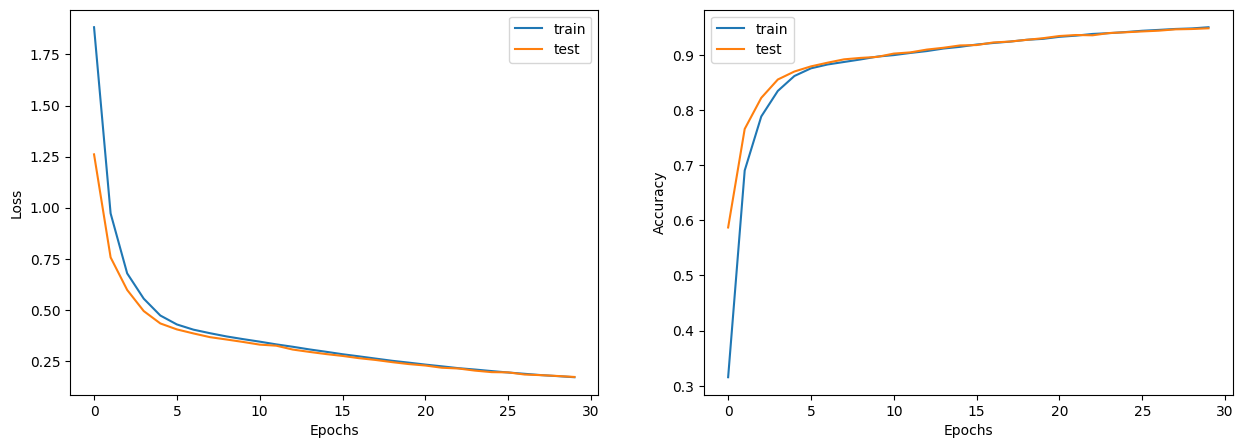

In [6]:
net = Network().to(device)

results = train_classifier(net, trainloader, testloader, n_epochs=30)
plot_history(results)

To get a better sense of our training, we plot the confusion matrix for the test dataset.

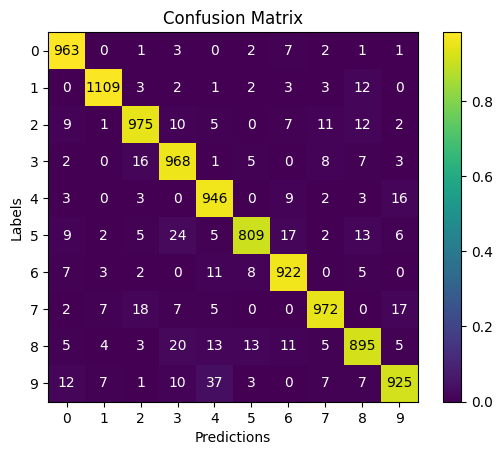

In [7]:
plot_conf_mat(net, testloader)

We then pass all test images through the network, capture the last hidden layer's output (before the final layer), and apply PCA and t-SNE for visualization:

PCA visualization:

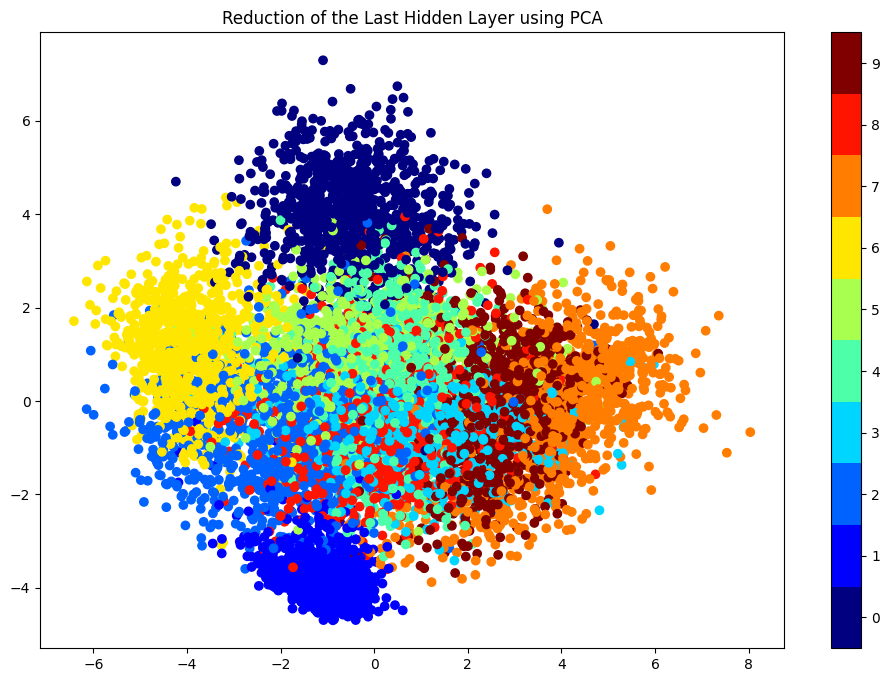

In [11]:
plot_last_hidden_layer(net, testloader, method='PCA')

t-SNE visualization:

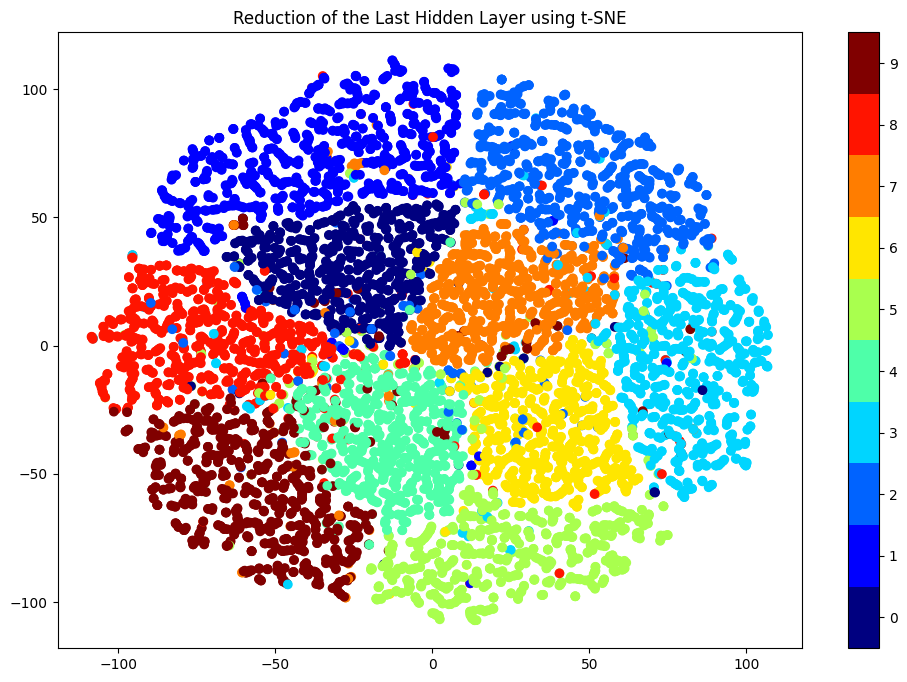

In [9]:
plot_last_hidden_layer(net, testloader, method='t-SNE')

For high accuracy, the last hidden layer should make datapoints from different classes linearly separable.

Additionally, in another Jupyter notebook, we use an autoencoder both for class representation on this dataset and for denoising images.